# Production Machine Learning Monitoring: Outliers, Drift, Explainers & Statistical Performance

This is the acompanying notebook to the blog post [Production Machine Learning Monitoring: Outliers, Drift, Explainers & Statistical Performance](https://towardsdatascience.com/production-machine-learning-monitoring-outliers-drift-explainers-statistical-performance-d9b1d02ac158).

In order to run thought this Notebook, you need to make sure you have the following setup:
* Seldon Core 1.5.0 (to the time of writing)
* Seldon Core Analytics
* KNative Eventing 0.18

## Train model

#### Import data

In [125]:
import logging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, \
    Dense, Layer, Reshape, InputLayer, Flatten

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

cifar_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#### Accessing the trained ML model provided

To simplify the interaction we have made available a tensorflow Resnet32 model trained with the CIFAR10 dataset.

We'll be able to access this through the file provided in this public google bucket: `gs://seldon-models/tfserving/cifar10/resnet32`.

We can copy it locally with the following command:

In [68]:
from alibi_detect.utils.fetching import fetch_tf_model

model = fetch_tf_model('cifar10', 'resnet32')

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


#### (Optional) Training the model yourself

The Alibi project provides a set of helpers that we can use to train the model. 

This uses the resnet32 model so it will take quite a few minutes even on a GPU.

If you still want to train it yourself you can run the command below, alternatively we provide an uploaded model which we'll use.

In [191]:
!git clone https://github.com/SeldonIO/alibi-detect --branch v0.4.3

!mkdir -p resnet32

!python alibi-detect/alibi_detect/models/resnet.py --serving True --model_dir ./resnet32

RandomForestClassifier(n_estimators=50)

This trains and exports our model in to the ./resnet32/ folder.

#### Test Model Locally

Once you follow one of the methods above, you are able to test the model locally.

For this we have to load it with Tensorflow and then run a data instance through it.

In [69]:
X_curr = X_train[1:2]

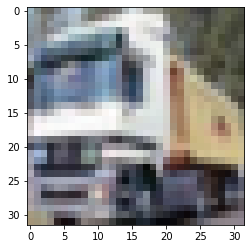

In [70]:
plt.imshow(X_curr[0])

In [72]:
X_curr_pred = model.predict(X_curr)
X_curr_pred

array([[7.7583492e-05, 2.7877894e-07, 1.8950082e-06, 9.6625229e-07,
        5.4822998e-08, 1.8315133e-08, 2.0955643e-07, 2.5767636e-06,
        5.8684610e-03, 9.9404800e-01]], dtype=float32)

Prediction result based on model:

In [73]:
cifar_classes[np.argmax(X_curr_pred)]

'truck'

## Deploy model

First we need to make sure that the model is available in an object store so we can deploy it via Kubernetes.

In this example we can simply push the model to google bucket (althoguh it's also possible to use Minio or other provider).

In [ ]:
!gsutil cp -r ./resnet32/ <yourbuckethere>

In [7]:
%%bash
kubectl apply -f - << END

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
    name: default
    replicas: 1
    
END

seldondeployment.machinelearning.seldon.io/cifar10 created


In [9]:
!kubectl get pods | grep cifar

cifar10-default-0-resnet32-6dc5f5777-sq765   2/2     Running   0          4m50s


In [527]:
import requests
X_curr = X_train[1:2]

pred = requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": X_curr.tolist() }).json()

print(pred)

print(f'\nPrediction: {cifar_classes[np.argmax(pred["predictions"][0])]}')

{'predictions': [[1.26448288e-06, 4.88144e-09, 1.51532642e-09, 8.49054249e-09, 5.51306611e-10, 1.16171261e-09, 5.77286274e-10, 2.88394716e-07, 0.00061489339, 0.999383569]]}

Prediction: truck


## Performance Monitoring

In [ ]:
import time
for X_i in X_test:
    requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": [X_i.tolist()] })
    time.sleep(0.1)

### Cluster Performance Metrics

![](img/k8s-perf.jpg)

### Model Performance Metrics

![](img/perf.jpg)

## Setup Eventing Infrastructure

In [ ]:
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/eventing-crds.yaml
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/eventing-core.yaml
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/in-memory-channel.yaml
!kubectl apply --filename https://github.com/knative/eventing/releases/download/v0.19.0/mt-channel-broker.yaml

In [21]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1
kind: Broker
metadata:
  name: default
spec: {}
END

broker.eventing.knative.dev/default unchanged


In [22]:
!kubectl get broker

NAME      URL                                                                        AGE     READY   REASON
default   http://broker-ingress.knative-eventing.svc.cluster.local/default/default   5d19h   True    


### Configure request Logger

In [ ]:
%%bash
kubectl apply -f - << END

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
      logger:
        url: http://broker-ingress.knative-eventing.svc.cluster.local/default/default
        mode: all
    name: default
    replicas: 1
    
END

## Statistical Metrics

In [473]:
%%bash
kubectl apply -f - << END
apiVersion: apps/v1
kind: Deployment
metadata:
  name: cifar10-model-metrics
  labels:
    app: cifar10-model-metrics
spec:
  replicas: 1
  selector:
    matchLabels:
      app: cifar10-model-metrics
  template:
    metadata:
      annotations:
        prometheus.io/path: "/v1/metrics"
        prometheus.io/scrape: "true"
      labels:
        app: cifar10-model-metrics
    spec:
      securityContext:
          runAsUser: 8888
      containers:
      - name: user-container
        image: seldonio/alibi-detect-server:1.6.0-dev
        imagePullPolicy: Never
        args:
        - --model_name
        - multiclassserver
        - --http_port
        - '8080'
        - --protocol
        - seldonfeedback.http
        - --storage_uri
        - "adserver.cm_models.multiclass_one_hot.MulticlassOneHot"
        - --reply_url
        - http://broker-ingress.knative-eventing.svc.cluster.local/default/default      
        - --event_type
        - io.seldon.serving.feedback.metrics
        - --event_source
        - io.seldon.serving.feedback
        - MetricsServer
        env:
        - name: "SELDON_DEPLOYMENT_ID"
          value: "cifar10"
        - name: "PREDICTIVE_UNIT_ID"
          value: "classifier"
        - name: "PREDICTIVE_UNIT_IMAGE"
          value: "alibi-detect-server:1.6.0-dev"
        - name: "PREDICTOR_ID"
          value: "default"
        ports:
        - containerPort: 8080
          name: metrics
          protocol: TCP
---
apiVersion: v1
kind: Service
metadata:
  name: cifar10-model-metrics
  labels:
    app: cifar10-model-metrics
spec:
  selector:
    app: cifar10-model-metrics
  ports:
    - protocol: TCP
      port: 80
      targetPort: 8080
END

deployment.apps/cifar10-model-metrics created
service/cifar10-model-metrics created


In [480]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: cifar10-model-metrics-trigger
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.feedback
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: cifar10-model-metrics
END

trigger.eventing.knative.dev/cifar10-model-metrics-trigger configured


In [481]:
!kubectl get trigger

NAME                               BROKER    SUBSCRIBER_URI                                               AGE     READY   REASON
cifar10-drift-detector-trigger     default   http://cifar10-drift-detector.default.svc.cluster.local/     67m     True    
cifar10-model-metrics-trigger      default   http://cifar10-model-metrics.default.svc.cluster.local/      11m     True    
cifar10-outlier-detector-trigger   default   http://cifar10-outlier-detector.default.svc.cluster.local/   4d22h   True    


### Send Feedback data
Although it's possible to send asynchronous feedback that is fetched from elasticsearch, for simplicity we will be sending self contained feedback requests which will contain the "response" and "truth" to simplify the workflow to start seeing metrics.

In [490]:
import requests
import random

N_CLASSES = 10
PER_CLASS = 10

def send_feedback(proba):
    
    for i in range(N_CLASSES):
        for j in range(PER_CLASS):
            r = [0] * N_CLASSES
            t = [0] * N_CLASSES
            r[i] = 1
            if random.random() * 100 < proba:
                t = r
            else:
                t[(i+1) % N_CLASSES] = 1
            f_req = {"response": {"data": { "ndarray": r }}, "truth": {"data": { "ndarray": t }}}

            requests.post("http://localhost:80/seldon/default/cifar10/api/v1.0/feedback", 
                         json=f_req)

#### Send feedback equivallent to 90% accuracy

In [ ]:
send_feedback(90)

#### Send feedback equivallent to 40% accuracy

In [ ]:
send_feedback(40)

#### Visualise metrics on grafana
![](img/stat-metrics.jpg)

## Outlier Detector

We are using the [Alibi Detect Variational Auto Encoder outlier detector](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_vae_cifar10.html).

As covered in the documentation, the Variational Auto-Encoder (VAE) outlier detector is first trained on a batch of unlabeled, but normal (inlier) data. Unsupervised training is desireable since labeled data is often scarce. The VAE detector tries to reconstruct the input it receives. If the input data cannot be reconstructed well, the reconstruction error is high and the data can be flagged as an outlier. The reconstruction error is either measured as the mean squared error (MSE) between the input and the reconstructed instance or as the probability that both the input and the reconstructed instance are generated by the same process.

In [109]:
!mkdir -p detector

In [110]:
!ls detector/OutlierVAE/

ls: cannot access 'detector/OutlierVAE/': No such file or directory


In [111]:
load_outlier_detector = True

In [113]:
!pwd

/home/alejandro/Programming/kubernetes/seldon/seldon_experiments/monitoring-talk


In [116]:
filepath = '/home/alejandro/Programming/kubernetes/seldon/seldon_experiments/monitoring-talk/detector' 
if load_outlier_detector: 
    from alibi_detect.utils.fetching import fetch_detector
    import os
    detector_type = 'outlier'
    dataset = 'cifar10'
    detector_name = 'OutlierVAE'
    od = fetch_detector(filepath, detector_type, dataset, detector_name)
    filepath = os.path.join(filepath, detector_name)
else:
    from alibi_detect.od import OutlierVAE
    from alibi_detect.models.losses import elbo
    import tensorflow as tf
    tf.keras.backend.clear_session()
    from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Layer, Reshape, InputLayer
    latent_dim = 1024

    encoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(32, 32, 3)),
          Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu)
      ])

    decoder_net = tf.keras.Sequential(
      [
          InputLayer(input_shape=(latent_dim,)),
          Dense(4*4*128),
          Reshape(target_shape=(4, 4, 128)),
          Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
          Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
      ])

    # initialize outlier detector
    od = OutlierVAE(threshold=.015,  # threshold for outlier score
                    score_type='mse',  # use MSE of reconstruction error for outlier detection
                    encoder_net=encoder_net,  # can also pass VAE model instead
                    decoder_net=decoder_net,  # of separate encoder and decoder
                    latent_dim=latent_dim,
                    samples=2)
    # train
    od.fit(X_train,
           loss_fn=elbo,
           cov_elbo=dict(sim=.05),
           epochs=50,
           verbose=False)
    
    # save the trained outlier detector
    save_detector(od, filepath)

### Check outliers by adding noise to images

In [133]:
from alibi_detect.utils.perturbation import apply_mask

all_X_mask = []
X_i = X_train[1].reshape(1, 32, 32, 3)
for j, mask_size in enumerate([(2*n,2*n) for n in range(1,10+1)]):
    X_mask, mask = apply_mask(X_i,
                              mask_size=mask_size,
                              n_masks=1,  # just 1 for visualization purposes
                              channels=[0,1,2],
                              mask_type='normal',
                              noise_distr=(0,1),
                              clip_rng=(0,1))
    all_X_mask.append(X_mask)
    

In [537]:
print(all_X_mask.shape)

(10, 32, 32, 3)


### Run Maksed Data Through Outlier

In [ ]:
all_X_mask = np.concatenate(all_X_mask, axis=0)
all_X_recon = od.vae(all_X_mask).numpy()
od_preds = od.predict(all_X_mask)

In [178]:
od.meta

{'name': 'OutlierVAE', 'detector_type': 'offline', 'data_type': 'image'}

In [177]:
od_preds["meta"]

{'name': 'OutlierVAE', 'detector_type': 'offline', 'data_type': 'image'}

In [534]:
od_preds["data"]["instance_score"]

array([0.00897947, 0.01056219, 0.01332702, 0.0182767 , 0.0217812 ,
       0.02888423, 0.03695648, 0.04850231, 0.05287006, 0.06678248])

In [535]:
od_preds["data"]["is_outlier"]

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

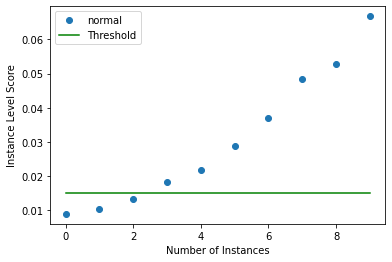

In [539]:
from alibi_detect.utils.visualize import plot_instance_score

labels = ['normal', 'outlier']
target = np.zeros(10,).astype(int)

plot_instance_score(od_preds, target, labels, od.threshold)

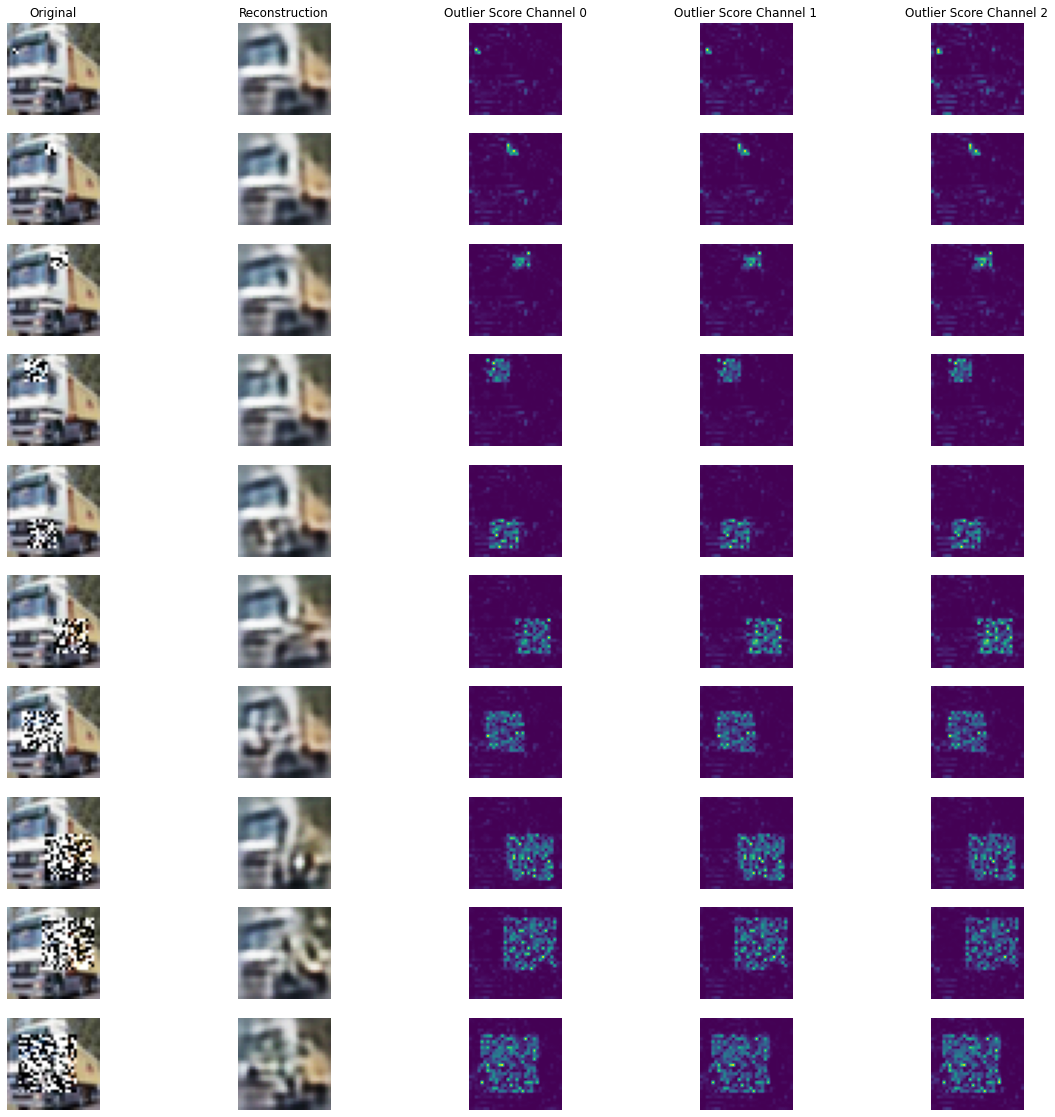

In [538]:
from alibi_detect.utils.visualize import plot_feature_outlier_image

plot_feature_outlier_image(od_preds,
                           all_X_mask,
                           X_recon=all_X_recon,
                           max_instances=all_X_mask.shape[0],
                           n_channels=3)

## Deploy Outlier Detector

In [207]:
%%bash
kubectl apply -f - << END
apiVersion: apps/v1
kind: Deployment
metadata:
  name: cifar10-outlier-detector
  labels:
    app: cifar10-outlier-detector
spec:
  replicas: 1
  selector:
    matchLabels:
      app: cifar10-outlier-detector
  template:
    metadata:
      annotations:
        prometheus.io/path: "/v1/metrics"
        prometheus.io/scrape: "true"
      labels:
        app: cifar10-outlier-detector
    spec:
      securityContext:
          runAsUser: 8888
      containers:
      - name: user-container
        image: seldonio/alibi-detect-server:1.6.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10od
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/od/OutlierVAE/cifar10
        - --reply_url
        - http://broker-ingress.knative-eventing.svc.cluster.local/default/default
        - --event_type
        - io.seldon.serving.inference.outlier
        - --event_source
        - io.seldon.serving.cifar10od
        - OutlierDetector
        ports:
        - containerPort: 8080
          name: metrics
          protocol: TCP
        env:
        - name: "SELDON_DEPLOYMENT_ID"
          value: "cifar10"
        - name: "PREDICTIVE_UNIT_ID"
          value: "classifier"
        - name: "PREDICTIVE_UNIT_IMAGE"
          value: "alibi-detect-server:1.6.0-dev"
        - name: "PREDICTOR_ID"
          value: "default"
---
apiVersion: v1
kind: Service
metadata:
  name: cifar10-outlier-detector
  labels:
    app: cifar10-outlier-detector
spec:
  selector:
    app: cifar10-outlier-detector
  ports:
    - protocol: TCP
      port: 80
      targetPort: 8080
END

deployment.apps/cifar10-outlier-detector configured
service/cifar10-outlier-detector unchanged


In [24]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: cifar10-outlier-detector-trigger
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: cifar10-outlier-detector
END

trigger.eventing.knative.dev/cifar10-outlier-detector-trigger unchanged


In [25]:
!kubectl get trigger

NAME                               BROKER    SUBSCRIBER_URI                                               AGE     READY   REASON
cifar10-outlier-detector-trigger   default   http://cifar10-outlier-detector.default.svc.cluster.local/   4d13h   True    


In [501]:
import requests

X_curr = X_train[1:2]

pred = requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": X_curr.tolist() }).json()
print(pred)

{'predictions': [[1.26448288e-06, 4.88144e-09, 1.51532642e-09, 8.49054249e-09, 5.51306611e-10, 1.16171261e-09, 5.77286274e-10, 2.88394716e-07, 0.00061489339, 0.999383569]]}


In [406]:
!kubectl run --quiet=true -it --rm curl --image=radial/busyboxplus:curl --restart=Never -- \
    curl -X GET -v "http://cifar10-outlier-detector.default.svc.cluster.local:80/v1/metrics"








# HELP seldon_metric_outlier_is_outlier_total 
# TYPE seldon_metric_outlier_is_outlier_total counter
seldon_metric_outlier_is_outlier_total{deployment_name="multiclass-model",image_name="alibi-detect-server",image_version="1.5.0-dev",index="0",method="io.seldon.serving.inference.outlier",model_image="alibi-detect-server",model_name="classifier",model_version="1.5.0-dev",predictor_name="default",predictor_version="NOT_IMPLEMENTED",seldon_deployment_name="multiclass-model",seldon_deployment_namespace="NOT_IMPLEMENTED",worker_id="d00893f2-3c81-11eb-990d-56c8aee52a83"} 0.0
# HELP seldon_metric_outlier_instance_score 
# TYPE seldon_metric_outlier_instance_score gauge
seldon_metric_outlier_instance_score{deployment_name="multiclass-model",image_name="alibi-detect-server",image_version="1.5.0-dev",index="0",method="io.seldon.serving.inference.outlier",model_image="alibi-detect-server",model_name="classifier",model_version="1.5.0-dev",predictor_name="default",predictor_version="NOT_IMPL

In [504]:
for x_mask in all_X_mask:
    requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": [x_mask.reshape(32,32,3).tolist()] })

{'predictions': [[0.0167943407, 0.00441808393, 0.00433646934, 0.834044516, 0.00197767862, 4.22939629e-05, 0.126700833, 3.03612542e-05, 0.0013890987, 0.0102664139]]}


In [409]:
!kubectl run --quiet=true -it --rm curl --image=radial/busyboxplus:curl --restart=Never -- \
    curl -X GET -v "http://cifar10-outlier-detector.default.svc.cluster.local:80/v1/metrics"

#### Visualise Outlier Detector in Dashboard
![](img/outlier.jpg)

## Drift Detector


In [451]:
!gsutil cp -r gs://seldon-models/alibi-detect/cd/ks/cifar10-0_4_3 cifarkstmp/

Copying gs://seldon-models/alibi-detect/cd/ks/cifar10-0_4_3/KSDrift.pickle...
Copying gs://seldon-models/alibi-detect/cd/ks/cifar10-0_4_3/meta.pickle...      
- [2 files][625.4 KiB/625.4 KiB]                                                
Operation completed over 2 objects/625.4 KiB.                                    


In [413]:
from alibi_detect.cd import KSDrift
from alibi_detect.cd.preprocess import UAE, HiddenOutput
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape

from alibi_detect.utils.saving import save_detector, load_detector

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)
uae = UAE(encoder_net=encoder_net)
preprocess_kwargs = {'model': uae, 'batch_size': 128}

# initialise drift detector
p_val = .05
cd = KSDrift(
    p_val=p_val,        # p-value for K-S test
    X_ref=X_test,       # test against original test set
    preprocess_X_ref=True,  # already preprocess X_ref at init stage to save time
    preprocess_kwargs=preprocess_kwargs,
    alternative='two-sided'  # other options: 'less', 'greater'
)

# we can also save/load an initialised detector
filepath = '/home/alejandro/Programming/kubernetes/seldon/seldon_experiments/monitoring-talk/drift' 
save_detector(cd, filepath)
cd = load_detector(filepath, **{'preprocess_kwargs': preprocess_kwargs})

In [416]:
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [420]:
X_c = []
n_corr = len(corruption)
for i in range(n_corr):
    X_c.append(X_corr[i * n_test : (i + 1) * n_test])

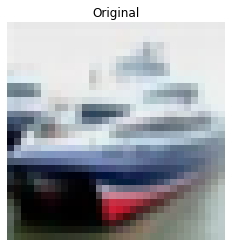

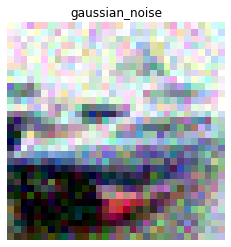

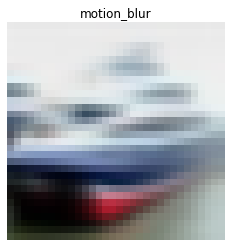

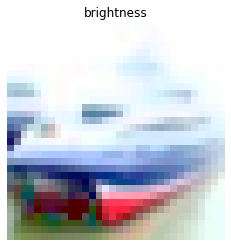

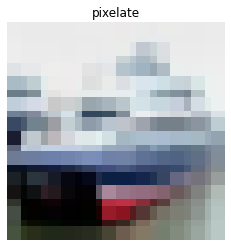

In [549]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()

for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

In [417]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [551]:
preds_h0 = cd.predict(X_h0, return_p_val=True)
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds_h0['data']['is_drift']]))

Drift? No!


In [552]:
for x, c in zip(X_c, corruption):
    preds = cd.predict(x, return_p_val=True)
    print(f'Corruption type: {c}')
    print('Drift? {}'.format(labels[preds['data']['is_drift']]))
    print('Feature-wise p-values:')
    print(preds['data']['p_val'])
    print('')

Corruption type: gaussian_noise
Drift? Yes!

Corruption type: motion_blur
Drift? Yes!

Corruption type: brightness
Drift? Yes!

Corruption type: pixelate
Drift? Yes!



### Deploy Drift Detector

In [460]:
%%bash
kubectl apply -f - << END
apiVersion: apps/v1
kind: Deployment
metadata:
  name: cifar10-drift-detector
spec:
  replicas: 1
  selector:
    matchLabels:
      app: cifar10-drift-detector
  template:
    metadata:
      annotations:
        prometheus.io/path: "/v1/metrics"
        prometheus.io/scrape: "true"
      labels:
        app: cifar10-drift-detector
    spec:
      securityContext:
          runAsUser: 8888
      containers:
      - name: user-container
        image: seldonio/alibi-detect-server:1.6.0-dev
        imagePullPolicy: IfNotPresent
        args:
        - --model_name
        - cifar10cd
        - --http_port
        - '8080'
        - --protocol
        - tensorflow.http
        - --storage_uri
        - gs://seldon-models/alibi-detect/cd/ks/drift
        - --reply_url
        - http://broker-ingress.knative-eventing.svc.cluster.local/default/default
        - --event_type
        - io.seldon.serving.inference.drift
        - --event_source
        - io.seldon.serving.cifar10cd
        - DriftDetector
        - --drift_batch_size
        - '1000'
        ports:
        - containerPort: 8080
          name: metrics
          protocol: TCP
        env:
        - name: "SELDON_DEPLOYMENT_ID"
          value: "cifar10"
        - name: "PREDICTIVE_UNIT_ID"
          value: "classifier"
        - name: "PREDICTIVE_UNIT_IMAGE"
          value: "alibi-detect-server:1.6.0-dev"
        - name: "PREDICTOR_ID"
          value: "default"
        - name: "ALIBI_DETECT_RETURN_INSTANCE_SCORE"
          value: "true"
---
apiVersion: v1
kind: Service
metadata:
  name: cifar10-drift-detector
  labels:
    app: cifar10-drift-detector
spec:
  selector:
    app: cifar10-drift-detector
  ports:
    - protocol: TCP
      port: 80
      targetPort: 8080
END

deployment.apps/cifar10-drift-detector configured
service/cifar10-drift-detector unchanged


In [430]:
%%bash
kubectl apply -f - << END
apiVersion: eventing.knative.dev/v1
kind: Trigger
metadata:
  name: cifar10-drift-detector-trigger
spec:
  broker: default
  filter:
    attributes:
      type: io.seldon.serving.inference.request
  subscriber:
    ref:
      apiVersion: v1
      kind: Service
      name: cifar10-drift-detector
END

trigger.eventing.knative.dev/cifar10-drift-detector-trigger created


In [431]:
!kubectl get trigger

NAME                               BROKER    SUBSCRIBER_URI                                               AGE     READY   REASON
cifar10-drift-detector-trigger     default   http://cifar10-drift-detector.default.svc.cluster.local/     7s      True    
cifar10-outlier-detector-trigger   default   http://cifar10-outlier-detector.default.svc.cluster.local/   4d21h   True    


In [506]:
for i, curr_x in enumerate(X_h0):
    if i % 100 == 0: print(i, end=", ")
    if i >= 1000: break
    requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                     json={ "instances": [curr_x.tolist()] })

0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 

### Confirm by checking metrics

In [447]:
!kubectl run --quiet=true -it --rm curl --image=radial/busyboxplus:curl --restart=Never -- \
    curl -X GET -v "http://cifar10-drift-detector.default.svc.cluster.local:80/v1/metrics" | grep "is_drift"

# HELP seldon_metric_drift_is_drift 
# TYPE seldon_metric_drift_is_drift gauge
seldon_metric_drift_is_drift{deployment_name="multiclass-model",image_name="alibi-detect-server",image_version="1.6.0-dev",index="0",method="io.seldon.serving.inference.drift",model_image="alibi-detect-server",model_name="classifier",model_version="1.6.0-dev",predictor_name="default",predictor_version="NOT_IMPLEMENTED",seldon_deployment_name="multiclass-model",seldon_deployment_namespace="NOT_IMPLEMENTED",worker_id="3f5360aa-3c8e-11eb-962a-fe057f6d206e"} 1.0
# HELP seldon_metric_drift_is_drift 
# TYPE seldon_metric_drift_is_drift gauge
seldon_metric_drift_is_drift{deployment_name="multiclass-model",image_name="alibi-detect-server",image_version="1.6.0-dev",index="0",method="io.seldon.serving.inference.drift",model_image="alibi-detect-server",model_name="classifier",model_version="1.6.0-dev",predictor_name="default",predictor_version="NOT_IMPLEMENTED",seldon_deployment_name="multiclass-model",seldon_deploymen

In [507]:
for x_set, c in zip(X_c, corruption):
    print(f'Corruption type: {c}')
    for i, curr_x in enumerate(x_set): 
        if i % 100 == 0: print(i, end=", ")
        if i >= 1000: break
        requests.post("http://localhost:80/seldon/default/cifar10/v1/models/resnet32/:predict", 
                         json={ "instances": [curr_x.tolist()] })
    print('')

Corruption type: gaussian_noise
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 
Corruption type: motion_blur
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 
Corruption type: brightness
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 
Corruption type: pixelate
0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 


In [441]:
!kubectl run --quiet=true -it --rm curl --image=radial/busyboxplus:curl --restart=Never -- \
    curl -X GET -v "http://cifar10-drift-detector.default.svc.cluster.local:80/v1/metrics" | grep "is_drift"

Error attaching, falling back to logs: 











### Visualise Drift Detectors on Dashboard
![](img/drift.jpg)

## Explainer

In [553]:
from alibi.explainers import AnchorImage

image_shape = (32, 32, 3)
segmentation_fn = 'slic'
kwargs = {'n_segments': 5, 'compactness': 20, 'sigma': .5}
explainer = AnchorImage(lambda x: model.predict(x), image_shape, segmentation_fn=segmentation_fn, 
                        segmentation_kwargs=kwargs, images_background=None)

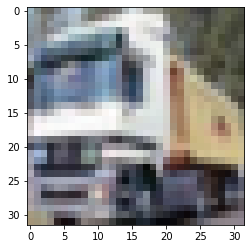

In [554]:
plt.imshow(X_curr[0])

In [80]:
np.random.seed(0)
explanation = explainer.explain(X_curr[0], threshold=.95, p_sample=.5, tau=0.25)

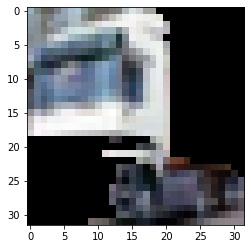

In [83]:
plt.imshow(explanation.anchor)

### Deploy Explainer

In [85]:
%%bash
kubectl apply -f - << END

apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
spec:
  protocol: tensorflow
  predictors:
  - graph:
      children: []
      implementation: TENSORFLOW_SERVER
      modelUri: gs://seldon-models/tfserving/cifar10/resnet32
      name: resnet32
      logger:
        url: http://broker-ingress.knative-eventing.svc.cluster.local/default/default
        mode: all
    explainer:
      type: AnchorImages
      modelUri: gs://seldon-models/tfserving/cifar10/explainer-py36-0.5.2
    name: default
    replicas: 1
    
END

seldondeployment.machinelearning.seldon.io/cifar10 configured


In [14]:
!kubectl get pods | grep cifar

cifar10-default-0-resnet32-6dc5f5777-sq765   2/2     Running   0          18m
cifar10-default-explainer-56cd6c76cd-mwjcp   1/1     Running   0          5m3s


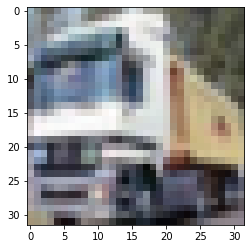

In [15]:
X_curr = X_train[1:2]

plt.imshow(X_curr[0])

In [16]:
import requests

exp = requests.post("http://localhost:80/seldon/default/cifar10-explainer/default/v1/models/resnet32:explain",
                     json={ "instances": X_curr.tolist() }).json()

print(f'Coverage: {exp["data"]["coverage"]}')
print(f'Precision: {exp["data"]["precision"]}')

Coverage: 0.2475
Precision: 1.0


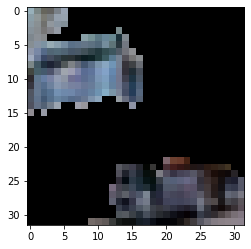

In [17]:
exp_img = np.array(exp["data"]["anchor"])
plt.imshow(exp_img)

In [522]:
print(exp["data"]["precision"])
print(exp["data"]["coverage"])

AnchorImage
['local']
['blackbox']

{'custom_segmentation': False, 'segmentation_kwargs': {'n_segments': 5, 'compactness': 20, 'sigma': 0.5}, 'p_sample': 0.5, 'seed': None, 'image_shape': [32, 32, 3], 'segmentation_fn': 'slic', 'kwargs': {}, 'verbose_every': 1, 'verbose': False, 'cache_margin': 1000, 'binary_cache_size': 10000, 'n_covered_ex': 10, 'min_samples_start': 100, 'max_anchor_size': None, 'stop_on_first': False, 'beam_size': 1, 'coverage_samples': 10000, 'batch_size': 100, 'tau': 0.15, 'delta': 0.1, 'threshold': 0.95}

1.0
0.2475
